In [1]:
import pandas as pd
import numpy as np
import reframed
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as st
import sys 
sys.path.append('../../../code/')
import leakage
from matplotlib.colors import LogNorm, Normalize

from matplotlib import cm, colors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn import metrics

In [2]:
folder = Path('../../../data/vila_2023/')



# Read in experimental data


In [3]:
targeted_fn = folder / 'Targeted_LCMS.csv'
dft = pd.read_csv(targeted_fn)
dft.rename(columns = {'Carbon_Source': 'Carbon source', 'Metabolite_Conc': 'Concentration'}, inplace=True)

In [4]:
exomet_carbon_sources = dft['Carbon source'].unique()

In [5]:
growth_fn = folder / 'Growth_Rates_Fig2.csv'
growth_df = pd.read_csv(growth_fn)

In [6]:
sanger_to_strain = {
    160: 'Enterobacter', # Targeted data
    162: 'Pseudomonas', # Targeted data
    360: 'Enterobacter', # Untargeted data
    449: 'Pseudomonas' # Untargeted data
}

In [7]:
# For this analysis we are only interested in the targeted data
growth_df = growth_df.loc[growth_df.SangerID.isin([160, 162])]

# Estimate biomass AUC at 16h
We have to predict the Biomass AUC from estimated rates, carrying capacity and initial abundance since we don't have the time-series data. However, since we know that they have fitted a logistic function using growthcurver (https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1016-7), we can use this function to get the auc after 16h (which corresponds to their first timepoint, more or less at the end of exponential phase).


In [8]:
# Compensate for N0 not being at T=0 (T0 = 1)
growth_df['T'] = growth_df.T16 - growth_df.T0

### Define logistic function (as defined in growthcurver) and the integral of that function

In [9]:
def logistic_auc(t1,t0, K, r, N0):
    return logistic_integral(t1,K,r,N0)-logistic_integral(t0,K,r,N0)
    
def logistic_integral(t, K, r, N0):
    return K*t + (K/r)*np.log(1+(((K-N0)/N0))*np.exp(-1*r*t))
    

def logistic(t, K, r, N0):
    return K/(1+((K-N0)/N0*np.exp(-1*r*t)))
    

In [10]:
# gcr is the growth rate obtained from growthcurver 
growth_df['AUC16'] = growth_df.apply(lambda x: logistic_auc(t1 = x['T'],t0 = 0, K = x['max_OD'], r = x['gcr'], N0 = x['N0']), axis=1)

In [11]:
gDW_per_OD = {
    'Enterobacter': 0.346, # Use same as for E. coli in galactose
    'Pseudomonas': np.mean([0.448, 0.505]) #pmc.ncbi.nlm.nih.gov/articles/PMC7809481/ https://pmc.ncbi.nlm.nih.gov/articles/PMC4656820
}

In [12]:
growth_df['Strain'] = growth_df['SangerID'].map(sanger_to_strain)

In [13]:
growth_df['AUC16gDW'] = growth_df.AUC16*growth_df.Strain.map(gDW_per_OD)

# Estimate rates

In [14]:
idx = (dft.Timepoint==16)&(dft.Strain.isin(['Enterobacter', 'Pseudomonas']))
df_rate = pd.merge(left=dft.loc[idx], right = growth_df, left_on=('Carbon source', 'Strain'), right_on=('CS', 'Strain'), how = 'left')

In [15]:
df_rate['Rate [mmol/gDW/h]'] = df_rate.Concentration/df_rate.AUC16gDW*1e-3 # 1e-3 to convert from uM to mM

In [16]:
df_meanrate = df_rate.groupby(['Metabolite', 'Strain', 'Carbon source']).agg({'Rate [mmol/gDW/h]': ('mean', 'sem', 'std')}).reset_index()

# Load metabolic models to estimate values

In [17]:
model_ez = reframed.load_cbmodel('../../../models/e_coli/momentiJO1366_modified.xml')
model_ez.solver = 'gurobi'
model_ez.reactions.R_EX_glc__D_e.lb = 0

In [18]:
model_pp_fn = '../../../models/p_putida/eciJN1463_uniprot_AutoPACMEN.xml'
# '../../../models/p_putida/iJN1463.xml'
model_pp = reframed.load_cbmodel(model_pp_fn)


model_pp.solver = 'gurobi'

model_pp.reactions.R_EX_glc__D_e.lb = 0

### Verify that models have all corbon source uptake blocked

In [19]:
reframed.FBA(model_ez, objective=model_ez.biomass_reaction)

Set parameter Username
Set parameter LicenseID to value 2586336
Academic license - for non-commercial use only - expires 2025-11-18


Objective: None
Status: Infeasible or Unbounded

In [20]:
reframed.FBA(model_pp, objective=model_pp.biomass_reaction)

Objective: None
Status: Infeasible or Unbounded

In [21]:
strain_to_model = {
    'Enterobacter': model_ez,
    'Pseudomonas': model_pp,
}

# Mapping of metabolite names to bigg ids


In [22]:
translate_dict = {'alpha-Ketoglutaric acid': 'akg',
'Butyric acid': 'but',
'Valine': 'val__L',
'Pyruvic acid': 'pyr',
'Propionic acid': 'ppa',
'Acetyl-ornithine': 'acorn',
'Alanine': 'ala__L',
'Acetic acid': 'ac',
'Asparagine': 'asn__L',
'beta-Hydroxybutyric acid': 'bhb',
'Serine': 'ser__L',
'Glycine': 'gly',
'Succinic acid': 'succ',
'Methionine': 'met__L',
'Fumaric acid': 'fum',
'Valeric acid': 'pta',
'Citric acid': 'cit',
'Lactic acid': 'lac__L',
'Putrescine':  'ptrc',
'Hippuric acid': 'bgly'}
translate_dict_r = {value:key for key, value in translate_dict.items()}

In [23]:
cs_to_exchange = {'D-Glucose': 'EX_glc__D_e',
                'D-Lactate': 'EX_lac__D_e',
                'Citrate': 'EX_cit_e',
                '2-Oxoglutarate': 'EX_akg_e',
                'Succinate': 'EX_succ_e',
                'Fumarate': 'EX_fum_e',
                'L-Malate': 'EX_mal__L_e',
                'L-Glutamine': 'EX_gln__L_e',
                'Acetate': 'EX_ac_e',
                'D-Galactose': 'EX_gal_e',
                'D-Ribose': 'EX_rib__D_e',
                'L-Arabinose': 'EX_arab__L_e',
                'Glycerol': 'EX_glyc_e',
                'D-Gluconate': 'EX_glcn_e',
                '2-Ketogluconate': 'EX_25dkglcn_e',
                'Pyruvate': 'EX_pyr_e',
                'D-Fructose': 'EX_fru_e'}


In [24]:
measured_mets_ez = []
measured_metnames_ez = []
for key, value in translate_dict.items():
    m_id = f'M_{value}_c'
    try:
        m = model_ez.metabolites[m_id]
    except KeyError:
        print(f'{key} not in model')
    else:
        measured_mets_ez.append(m_id)
        measured_metnames_ez.append(key)

beta-Hydroxybutyric acid not in model
Valeric acid not in model
Hippuric acid not in model


In [25]:
measured_mets_pp = []
measured_metnames_pp = []
for key, value in translate_dict.items():
    m_id = f'M_{value}_c'
    try:
        m = model_pp.metabolites[m_id]
    except KeyError:
        print(f'{key} not in model')
    else:
        measured_mets_pp.append(m_id)
        measured_metnames_pp.append(key)

Hippuric acid not in model


In [26]:
metnames_dict = {
    'Enterobacter': (measured_mets_ez, measured_metnames_ez),
    'Pseudomonas': (measured_mets_pp, measured_metnames_pp)
}

In [27]:
df_rate['Carbon source'].unique()

array(['D-Glucose', 'L-Malate', 'D-Fructose', 'Glycerol', 'Pyruvate'],
      dtype=object)

## Estimate uptake rates from maximum growth rates


In [28]:
uptake_rates = []
uptake_dict = {}
for i, row in growth_df.iterrows():
    if not row['CS'] in exomet_carbon_sources:
        uptake_rates.append(np.nan)
        # Not interested in these
        continue
    
    model = strain_to_model[row['Strain']]
    r_ex = f"R_{cs_to_exchange[row['CS']]}"

    if not r_ex in model.reactions:
        print(f'{r_ex} not in {model.id}')
        uptake_rates.append(np.nan)
        continue
    
    growth_rate = row['r']
    print(row['CS'], row['Strain'])
    sol = reframed.FBA(model, constraints = {r_ex:(-10,0), model.biomass_reaction:(growth_rate,growth_rate)},
                      objective = {r_ex:1})
    uptake_rates.append(sol.fobj)
    uptake_dict[(row['Strain'], row['CS'])] = sol.fobj
    

D-Glucose Enterobacter
D-Fructose Enterobacter
D-Galactose Enterobacter
D-Ribose Enterobacter
L-Arabinose Enterobacter
Glycerol Enterobacter
Pyruvate Enterobacter
Succinate Enterobacter
Fumarate Enterobacter
L-Malate Enterobacter
Acetate Enterobacter
D-Glucose Pseudomonas
D-Fructose Pseudomonas
R_EX_gal_e not in eciJN1463_uniprot_AutoPACMEN
D-Ribose Pseudomonas
R_EX_arab__L_e not in eciJN1463_uniprot_AutoPACMEN
Glycerol Pseudomonas
Pyruvate Pseudomonas
Succinate Pseudomonas
Fumarate Pseudomonas
L-Malate Pseudomonas
Acetate Pseudomonas


In [29]:
growth_df['Uptake rate'] = uptake_rates

# Now calaculate shadow prices
Can't estimate shadow price / metabolite value for butyrate because all reactions related to butyrate are blocked. 

In [30]:
sp_dict = {}
for strain, model in strain_to_model.items():
    dfs = df_rate.loc[df_rate.Strain==strain]
    for cs in dfs['Carbon source'].unique():
        r_ex = f"R_{cs_to_exchange[cs]}"
        uptake_rate = uptake_dict[(strain, cs)]
        if not uptake_rate:
            continue
        measured_mets, measured_metnames = metnames_dict[strain]
        sp_dict[(strain, cs)] = leakage.estimate_shadow_prices_reframed(model, 
                                constraints={r_ex:(uptake_rate, uptake_rate)},
                                delta = 0.01, metabolites=measured_mets)


In [31]:
mv_df = (pd.DataFrame(sp_dict)*-1).reset_index()

In [32]:
mv_df.columns

MultiIndex([(       'index',           ''),
            ('Enterobacter',  'D-Glucose'),
            ('Enterobacter',   'L-Malate'),
            ('Enterobacter', 'D-Fructose'),
            ('Enterobacter',   'Glycerol'),
            ('Enterobacter',   'Pyruvate'),
            ( 'Pseudomonas',  'D-Glucose'),
            ( 'Pseudomonas',   'L-Malate'),
            ( 'Pseudomonas', 'D-Fructose'),
            ( 'Pseudomonas',   'Glycerol'),
            ( 'Pseudomonas',   'Pyruvate')],
           )

In [33]:
mv_dfL = mv_df.melt(id_vars=[('index','')], value_vars=list(mv_df.columns), 
                    value_name='Metabolite value [gDW/mmol]').rename(columns = {'variable_0':'Strain', 
                    'variable_1': 'Carbon source', ('index', ''):'Metabolite ID'})



In [34]:
mv_dfL['Metabolite ID'] = mv_dfL['Metabolite ID'].str.replace('M_', '').str.replace('_c','')

In [35]:
mv_dfL['Metabolite'] = mv_dfL['Metabolite ID'].map(translate_dict_r)

In [36]:
df_meanrate.columns = ['Metabolite', 'Strain', 'Carbon source', 'Rate [mmol/gDW/h]',
                      'Std. Err [mmol/gDW/h]','Std. Dev [mmol/gDW/h]']

In [37]:
df = pd.merge(left = df_meanrate, right = mv_dfL, left_on=('Metabolite', 'Strain', 'Carbon source'),
             right_on=('Metabolite', 'Strain', 'Carbon source'))

In [38]:
df['log10(Rate [mmol/gDW/h])'] = np.log10(df['Rate [mmol/gDW/h]'])
df['log10(Metabolite value [gDW/mmol])'] = np.log10(df['Metabolite value [gDW/mmol]'])

/Users/snorre/miniconda3/envs/reframed/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Store results

In [39]:
rates_fn = folder / 'vila_2023_rates_and_values.csv'
df.to_csv(rates_fn)

In [40]:
df_notnan = df.replace(-np.inf, np.nan).dropna()

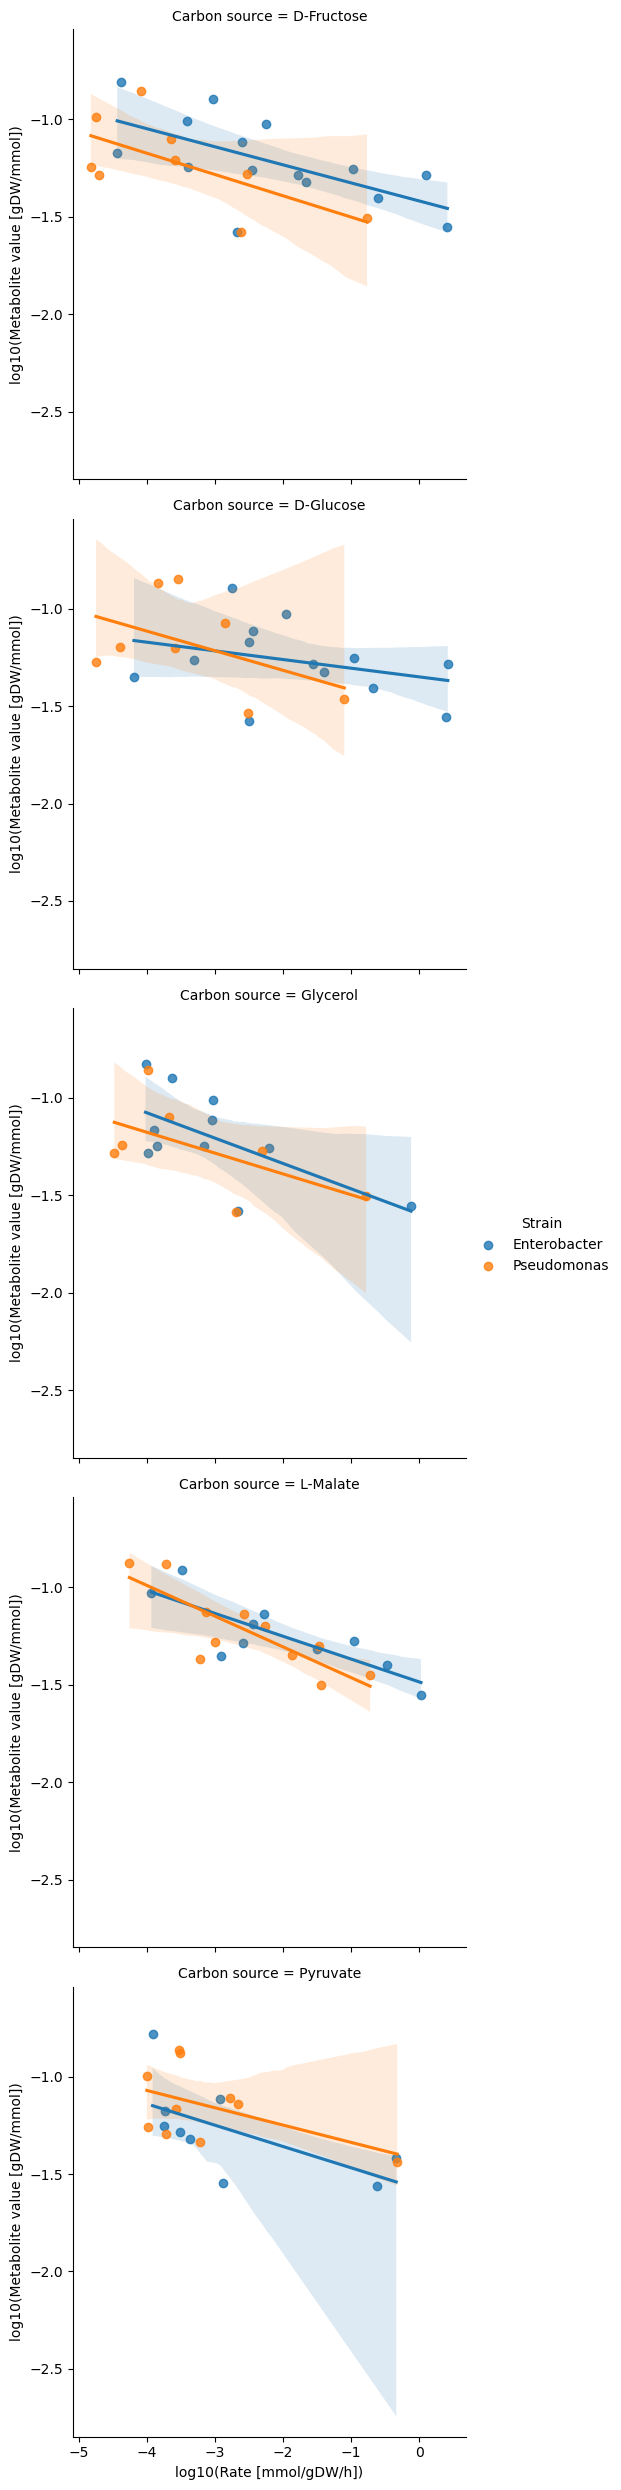

In [41]:
sns.lmplot(data = df_notnan, x = 'log10(Rate [mmol/gDW/h])',
           y = 'log10(Metabolite value [gDW/mmol])', hue = 'Strain', col = 'Carbon source', col_wrap=1)


In [42]:
df.loc[df.isna().any(axis=1)]

,Metabolite,Strain,Carbon source,Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],Std. Dev [mmol/gDW/h],Metabolite ID,Metabolite value [gDW/mmol],log10(Rate [mmol/gDW/h]),log10(Metabolite value [gDW/mmol])
40,Butyric acid,Enterobacter,D-Fructose,0.000244,0.000178,0.000252,but,NaN,-3.613041,NaN
41,Butyric acid,Enterobacter,D-Glucose,0.000000,0.000000,0.000000,but,NaN,-inf,NaN
42,Butyric acid,Enterobacter,Glycerol,0.000819,0.000160,0.000227,but,NaN,-3.086756,NaN
43,Butyric acid,Enterobacter,L-Malate,0.000000,0.000000,0.000000,but,NaN,-inf,NaN
44,Butyric acid,Enterobacter,Pyruvate,0.000000,0.000000,0.000000,but,NaN,-inf,NaN
45,Butyric acid,Pseudomonas,D-Fructose,0.000308,0.000212,0.000299,but,NaN,-3.511394,NaN
46,Butyric acid,Pseudomonas,D-Glucose,0.000000,0.000000,0.000000,but,NaN,-inf,NaN
47,Butyric acid,Pseudomonas,Glycerol,0.000618,0.000115,0.000163,but,NaN,-3.209299,NaN
48,Butyric acid,Pseudomonas,L-Malate,0.000225,0.000225,0.000318,but,NaN,-3.647830,NaN
49,Butyric acid,Pseudomonas,Pyruvate,0.000000,0.000000,0.000000,but,NaN,-inf,NaN


In [43]:
for strain in df_notnan.Strain.unique():
    # for cs in df_notnan['Carbon source'].unique():
    idx = (df_notnan.Strain==strain) #& (df_notnan['Carbon source']==cs)
    dfi = df_notnan.loc[idx]
    x = dfi['log10(Rate [mmol/gDW/h])']
    y = dfi['log10(Metabolite value [gDW/mmol])']
    print(strain, cs, st.pearsonr(x,y))

Enterobacter Pyruvate PearsonRResult(statistic=np.float64(-0.5644726269016239), pvalue=np.float64(3.928346405277608e-06))
Pseudomonas Pyruvate PearsonRResult(statistic=np.float64(-0.5756150692800642), pvalue=np.float64(3.5223434606607895e-05))


In [44]:
for strain in df_notnan.Strain.unique():
    # for cs in df_notnan['Carbon source'].unique():
    idx = (df_notnan.Strain==strain) #& (df_notnan['Carbon source']==cs)
    dfi = df_notnan.loc[idx]
    x = dfi['log10(Rate [mmol/gDW/h])']
    y = dfi['log10(Metabolite value [gDW/mmol])']
    print(strain, cs, st.pearsonr(x,y))

Enterobacter Pyruvate PearsonRResult(statistic=np.float64(-0.5644726269016239), pvalue=np.float64(3.928346405277608e-06))
Pseudomonas Pyruvate PearsonRResult(statistic=np.float64(-0.5756150692800642), pvalue=np.float64(3.5223434606607895e-05))


In [45]:
dfi

,Metabolite,Strain,Carbon source,Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],Std. Dev [mmol/gDW/h],Metabolite ID,Metabolite value [gDW/mmol],log10(Rate [mmol/gDW/h]),log10(Metabolite value [gDW/mmol])
5,Acetic acid,Pseudomonas,D-Fructose,0.171753,1.195496e-03,1.690687e-03,ac,0.031085,-0.765096,-1.507444
6,Acetic acid,Pseudomonas,D-Glucose,0.079440,2.182409e-02,3.086392e-02,ac,0.034233,-1.099963,-1.465552
7,Acetic acid,Pseudomonas,Glycerol,0.166165,1.010890e-02,1.429615e-02,ac,0.031438,-0.779460,-1.502540
8,Acetic acid,Pseudomonas,L-Malate,0.035835,3.788285e-03,5.357445e-03,ac,0.031456,-1.445691,-1.502298
16,Acetyl-ornithine,Pseudomonas,D-Glucose,0.000290,2.901320e-04,4.103086e-04,acorn,0.141310,-3.537404,-0.849828
18,Acetyl-ornithine,Pseudomonas,L-Malate,0.000194,2.201301e-05,3.113110e-05,acorn,0.131255,-3.712150,-0.881884
19,Acetyl-ornithine,Pseudomonas,Pyruvate,0.000303,2.709485e-05,3.831790e-05,acorn,0.131682,-3.518601,-0.880475
35,Asparagine,Pseudomonas,D-Fructose,0.000255,2.554377e-04,3.612435e-04,asn__L,0.061683,-3.592715,-1.209833
36,Asparagine,Pseudomonas,D-Glucose,0.000262,2.624026e-04,3.710933e-04,asn__L,0.062618,-3.581032,-1.203304
55,Citric acid,Pseudomonas,D-Fructose,0.000222,0.000000e+00,0.000000e+00,cit,0.079383,-3.652939,-1.100274
